In [93]:
import pandas as pd
import numpy as np
import os
import shutil
from shutil import copyfile
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output as cls

# Tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [57]:
dogs_count = len(os.listdir("PetImages/Dog/"))
cats_count = len(os.listdir("PetImages/Cat/"))

dogs_count,cats_count

(12501, 12501)

In [55]:
import pathlib
data_directory = pathlib.Path("PetImages")
class_names = np.array(sorted([item.name for item in data_directory.glob('*')]))
class_names

array(['Cat', 'Dog'], dtype='<U3')

In [17]:
root = ".\Data"
if os.path.exists(root):
    shutil.rmtree(root)

def create_directories(root_path):
    os.mkdir(root_path)
    train_dir = os.path.join(root_path,"train")
    os.mkdir(train_dir)
    test_dir = os.path.join(root_path,"test")
    os.mkdir(test_dir)
    print("train and test dir done")
    cats_train_dir = os.path.join(train_dir, "cats")
    os.mkdir(cats_train_dir)
    dogs_train_dir = os.path.join(train_dir,"dogs")
    os.mkdir(dogs_train_dir)
    print("Cats and Dogs for train done")
    cats_test_dir = os.path.join(test_dir, "cats")
    os.mkdir(cats_test_dir)
    dogs_test_dir = os.path.join(test_dir,"dogs")
    os.mkdir(dogs_test_dir)
    print("cats and dogs for test done")
try:
    create_directories(root_path=root)
except OSError:
    print("File already exists")

train and test dir done
Cats and Dogs for train done
cats and dogs for test done


In [18]:
for rootdir, dirs, files in os.walk(root):
    for subdir in dirs:
        print(os.path.join(root,subdir))

.\Data\test
.\Data\train
.\Data\cats
.\Data\dogs
.\Data\cats
.\Data\dogs


In [27]:
def splitting(source_dir,training_dir,testing_dir,split_size):
    source_list = os.listdir(source_dir)
    train_list = random.sample(source_list,int(len((source_list))*split_size))
    for img in source_list:
        if (os.path.getsize(os.path.join(source_dir,img))==0):
            print(img," size is zero!")
        elif img in train_list:
            copyfile(os.path.join(source_dir,img),os.path.join(training_dir,img))
        else:
            copyfile(os.path.join(source_dir,img),os.path.join(testing_dir,img))
    print("Done For: ",source_dir)

In [28]:
root

'.\\Data'

In [29]:
source_cat = "./PetImages/Cat/"
source_dog = "./PetImages/Dog/"

train_cat_path = "./Data/train/cats/"
train_dog_path = "./Data/train/dogs/"

test_cat_path = "./Data/test/cats/"
test_dog_path = "./Data/test/dogs/"

split = 0.8

splitting(source_cat,train_cat_path,test_cat_path,split)
splitting(source_dog,train_dog_path,test_dog_path,split)

666.jpg  size is zero!
Done For:  ./PetImages/Cat/
11702.jpg  size is zero!
Done For:  ./PetImages/Dog/


In [31]:
train_dog_count = len(os.listdir("./Data/train/dogs/"))
train_cat_count = len(os.listdir("./Data/train/cats/"))
test_dog_count = len(os.listdir("./Data/test/cats/"))
test_cat_count = len(os.listdir("./Data/test/dogs/"))

train_dog_count,train_cat_count,test_dog_count,test_cat_count

(9999, 9999, 2501, 2501)

In [85]:
train_dir = "./Data/train/"
test_dir = "./Data/test/"

train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

no need to pre_process data here, its only used for inceptionresnet later on!

In [86]:
train_set = train_data_generator.flow_from_directory(train_dir,target_size=(299,299),shuffle=True,class_mode="binary",batch_size=32,subset="training")
val_set = val_data_generator.flow_from_directory(train_dir,target_size=(299,299),shuffle=False,class_mode="binary",batch_size=32,subset="validation")
test_set = test_data_generator.flow_from_directory(test_dir, target_size=(299,299),shuffle=True,class_mode="binary",batch_size=32)

Found 16999 images belonging to 2 classes.
Found 2998 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.


In [87]:
# Number of samples and classes
nb_train_samples = train_set.samples
nb_validation_samples = val_set.samples
nb_test_samples = test_set.samples
classes = list(train_set.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)
print(nb_train_samples,nb_validation_samples,nb_test_samples)

Classes:['cats', 'dogs']
16999 2998 5001


In [88]:
images, labels = train_set.next()
len(images), len(labels)

(32, 32)

In [91]:
def show_image(image, title=None, show=False):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    if show:
        plt.show()

def show_images(data, class_names, model=None, GRID=[5,6], SIZE=(30,25)):

    # Configuration
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)

    # Iterate through the Data
    i = 1
    for images, labels in iter(data):
        
        # Select Image and label randomly
        id = np.random.randint(len(images))
        image, label = tf.expand_dims(images[id], axis=0), class_names[int(labels[id])]

        # Make prediction
        if model is not None:
            prediction = model.predict(image)[0]
            score = np.round(max(prediction), 2)
            pred = class_names[np.argmax(prediction)]
            title = f"True : {label}\nPred : {pred}\nScore : {score}"
        else:
            title = f"{label}"
        
        # Plot Image
        plt.subplot(n_rows, n_cols, i)
        show_image(image[0], title=title, show=False)

        # Clear Unnecessary text
        cls()

        # Once done break loop
        i+=1
        if i>n_images:
            break
    
    # Show Final Plot
    plt.show()

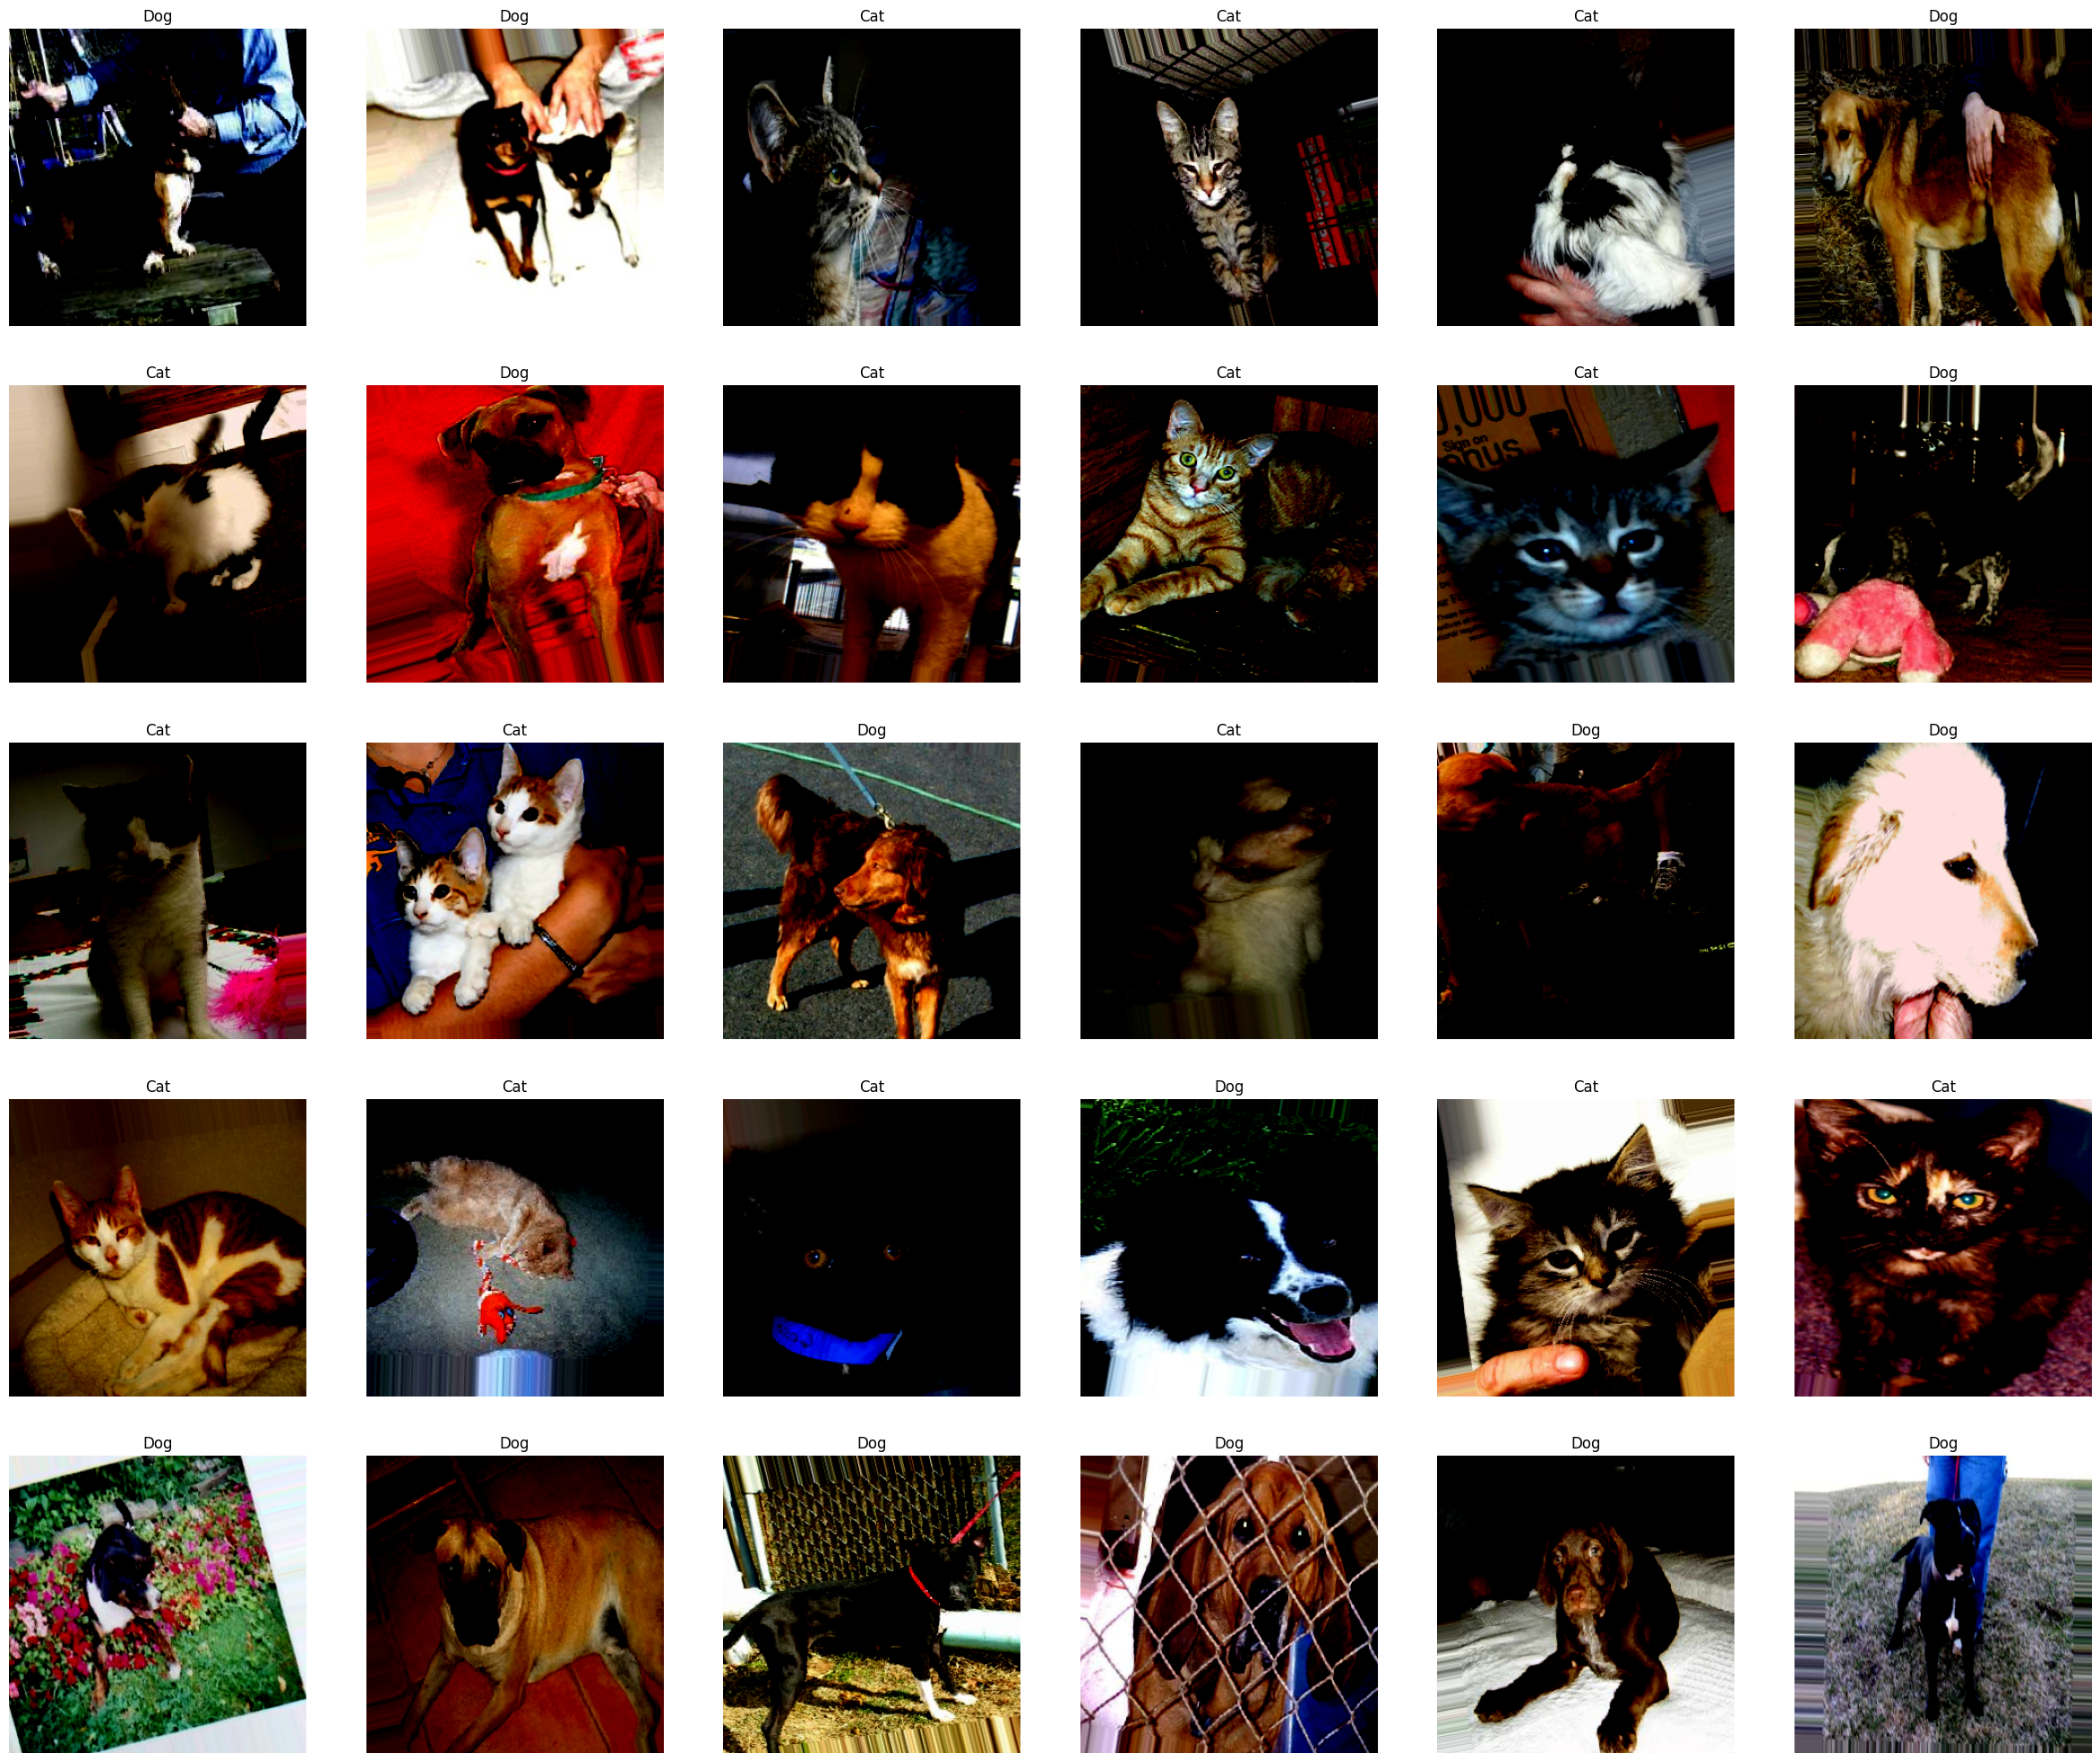

In [90]:
show_images(data=train_set,class_names=class_names)

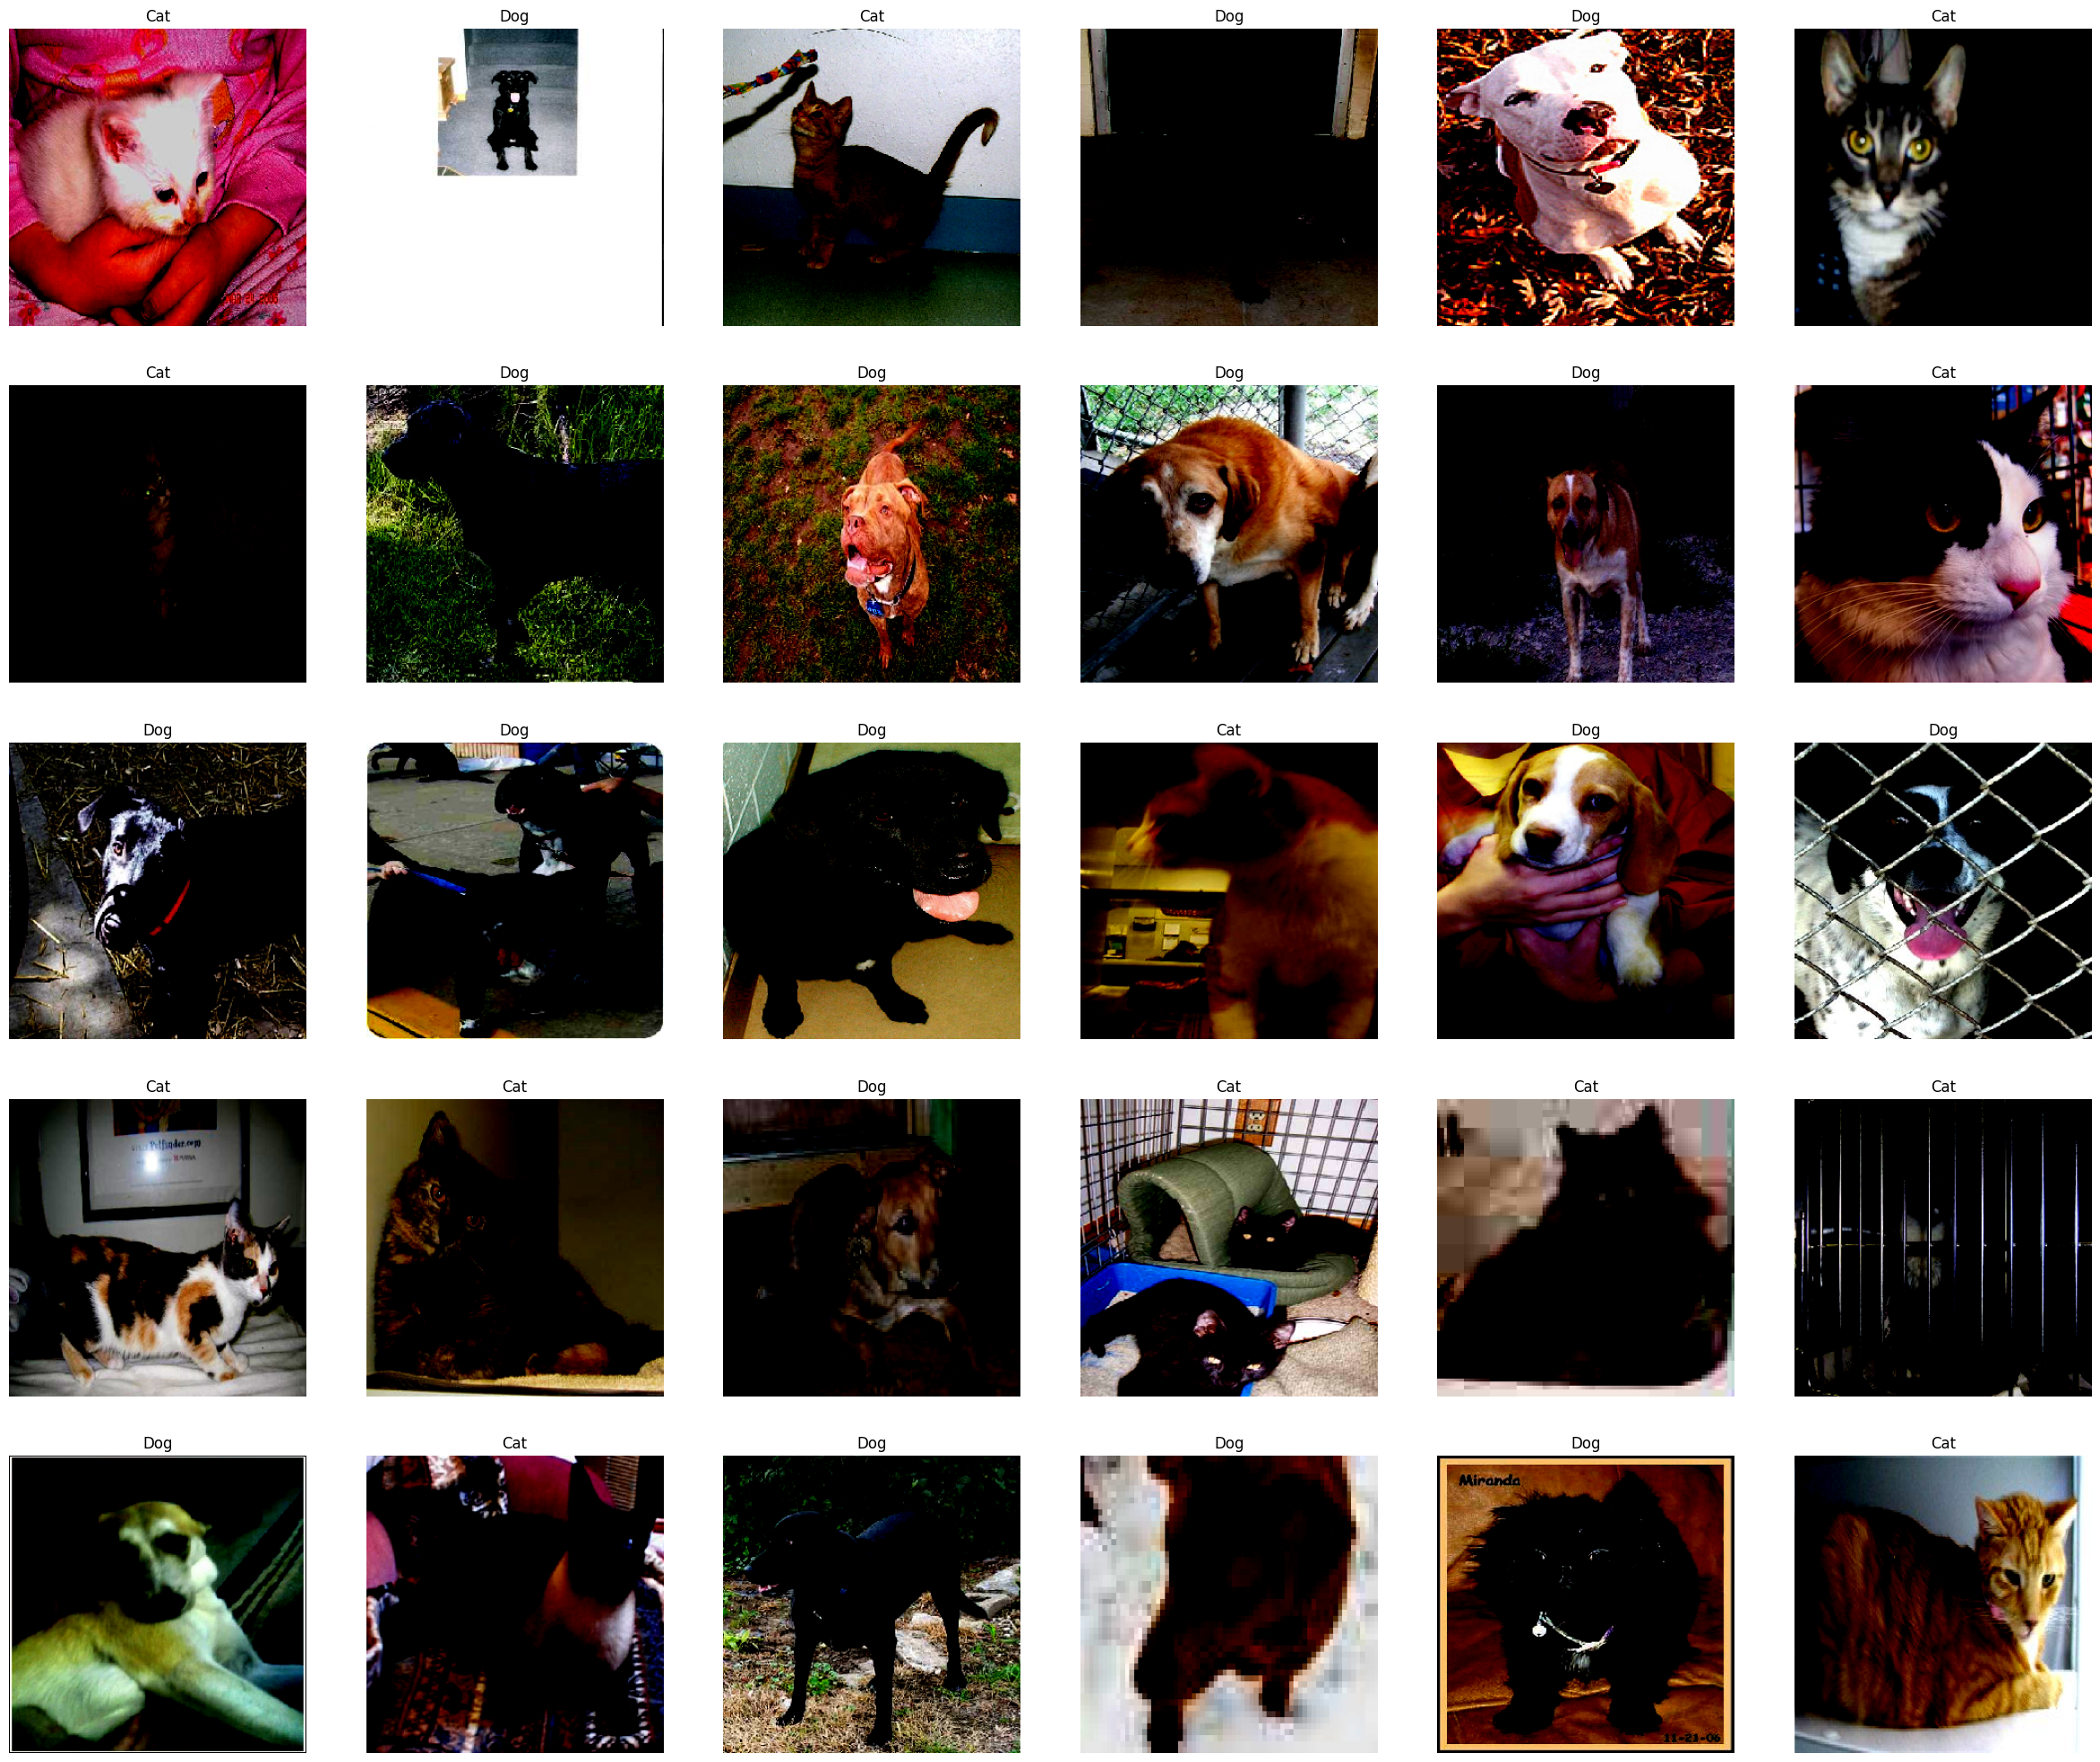

In [92]:
show_images(test_set,class_names)

Model building

In [97]:
train_set.image_shape,test_set.image_shape

((299, 299, 3), (299, 299, 3))

In [104]:
base_model = Sequential()
base_model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",input_shape = (299,299,3)))
base_model.add(MaxPool2D(pool_size=(2,2)))
base_model.add(Dropout(0.25))
base_model.add(MaxPool2D(pool_size=(2,2)))
base_model.add(Dropout(0.25))
base_model.add(Flatten())
base_model.add(Dense(256,activation="relu"))
base_model.add(Dropout(0.25))
base_model.add(Dense(128,activation="relu"))
base_model.add(Dense(1,activation="sigmoid"))

In [105]:
base_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 175232)           

In [106]:
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [134]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='MYmodel.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [113]:
history = base_model.fit(
        train_set,
        steps_per_epoch=nb_train_samples//512,
        epochs=100,
        callbacks=[es,save_checkpoint],
        validation_data=val_set,
        verbose=True,
        validation_steps=nb_validation_samples//512
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.6178
Epoch 1: val_loss improved from inf to 0.67399, saving model to model.h5
33/33 [==============================] - 14s 419ms/step - loss: 0.6440 - accuracy: 0.6178 - val_loss: 0.6740 - val_accuracy: 0.7625
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.6285
Epoch 2: val_loss improved from 0.67399 to 0.58432, saving model to model.h5
33/33 [==============================] - 14s 419ms/step - loss: 0.6512 - accuracy: 0.6285 - val_loss: 0.5843 - val_accuracy: 0.7688
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6269
Epoch 3: val_loss did not improve from 0.58432
33/33 [==============================] - 14s 416ms/step - loss: 0.6358 - accuracy: 0.6269 - val_loss: 0.8172 - val_accuracy: 0.5000
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6089
Epoch 4: val_loss did not i

c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


33/33 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6420
Epoch 19: val_loss did not improve from 0.44889
33/33 [==============================] - 13s 384ms/step - loss: 0.6166 - accuracy: 0.6420 - val_loss: 0.6587 - val_accuracy: 0.7250
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.6723
Epoch 20: val_loss did not improve from 0.44889
33/33 [==============================] - 13s 388ms/step - loss: 0.5911 - accuracy: 0.6723 - val_loss: 0.7356 - val_accuracy: 0.6250
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.6866
Epoch 21: val_loss did not improve from 0.44889
33/33 [==============================] - 13s 390ms/step - loss: 0.5834 - accuracy: 0.6866 - val_loss: 0.7194 - val_accuracy: 0.6750
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.6676
Epoch 22: val_loss did not improve from 0.44889
33/33 [==============================] - 

In [126]:
base_model_1 = Sequential()
base_model_1.add(Conv2D(filters=16,kernel_size=(3,3),strides=1,padding="valid",activation="relu",input_shape = (299,299,3)))
base_model_1.add(MaxPool2D(pool_size=(2,2)))
base_model_1.add(Dropout(0.25))
base_model_1.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation="relu"))
base_model_1.add(Dropout(0.25))
base_model_1.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,activation="relu"))
base_model_1.add(MaxPool2D(pool_size=(2,2)))
base_model_1.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation="relu"))
base_model_1.add(Dropout(0.25))
base_model_1.add(Conv2D(filters=16,kernel_size=(3,3),strides=1,activation="relu"))
base_model_1.add(MaxPool2D(pool_size=(2,2)))
base_model_1.add(Dropout(0.25))
base_model_1.add(Flatten())
base_model_1.add(Dense(256,activation="relu"))
base_model_1.add(Dropout(0.5))
base_model_1.add(Dense(128,activation="relu"))
base_model_1.add(Dense(1,activation="sigmoid"))

In [127]:
base_model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 148, 148, 16)     0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 148, 148, 16)      0         
                                                                 
 conv2d_32 (Conv2D)          (None, 146, 146, 32)      4640      
                                                                 
 dropout_26 (Dropout)        (None, 146, 146, 32)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 144, 144, 64)      18496     
                                                     

In [128]:
base_model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [131]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [135]:
history_2 = base_model_1.fit(
        train_set,
        steps_per_epoch=len(train_set),
        epochs=10,
        callbacks=[es,save_checkpoint],
        validation_data=val_set,
        validation_steps=len(val_set),
        verbose=True,
)

Epoch 1/10
189/532 [=========>....................] - ETA: 2:04 - loss: 0.5004 - accuracy: 0.7579

c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


532/532 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.7656
Epoch 1: val_loss improved from inf to 0.44378, saving model to MYmodel.h5
532/532 [==============================] - 198s 371ms/step - loss: 0.4892 - accuracy: 0.7656 - val_loss: 0.4438 - val_accuracy: 0.7942
Epoch 2/10
532/532 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7749
Epoch 2: val_loss did not improve from 0.44378
532/532 [==============================] - 195s 366ms/step - loss: 0.4770 - accuracy: 0.7749 - val_loss: 0.5072 - val_accuracy: 0.7452
Epoch 3/10
532/532 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.7808
Epoch 3: val_loss did not improve from 0.44378
532/532 [==============================] - 197s 370ms/step - loss: 0.4656 - accuracy: 0.7808 - val_loss: 0.5019 - val_accuracy: 0.7642
Epoch 4/10
532/532 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.7858
Epoch 4: val_loss improved from 0.44378 to 0.44071, s

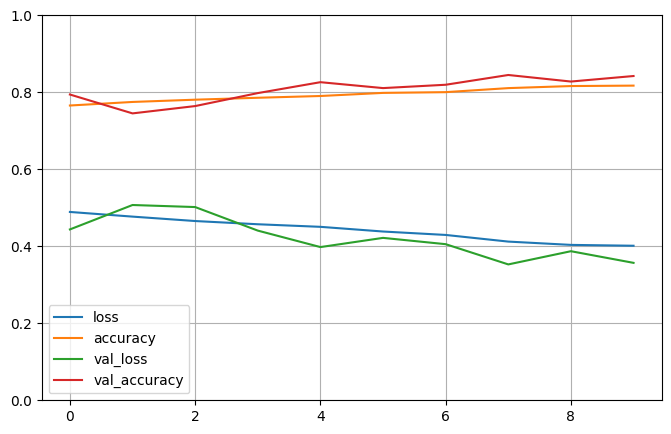

In [136]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [137]:
# Evaluate on validation dataset
score = base_model_1.evaluate(val_set, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.3569362461566925
Val accuracy: 0.8422281742095947


In [138]:
# Evaluate on test dataset
score = base_model_1.evaluate(test_set, verbose=True)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

157/157 [==============================] - 20s 125ms/step - loss: 0.3741 - accuracy: 0.8374
Val loss: 0.37410467863082886
Val accuracy: 0.8374325037002563


Using Inception ResNetV2

In [151]:
# Tensorflow
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [156]:
num_classes

2

In [160]:
# Pre-trained deep convolutional neural network
inception_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Add new layers
x = inception_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Build model
model = Model(inputs=inception_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in inception_model.layers:
    layer.trainable = False

# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [161]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='inception_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=True)

In [162]:
# Train model
history_3 = model.fit(
        train_set,
        steps_per_epoch=len(train_set),
        epochs=25,
        callbacks=[early_stopping,save_checkpoint],
        validation_data=val_set,
        verbose=True,
        validation_steps=len(val_set))

Epoch 1/25
532/532 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9831
Epoch 1: val_loss improved from inf to 0.05272, saving model to inception_model.h5
532/532 [==============================] - 236s 430ms/step - loss: 0.1956 - accuracy: 0.9831 - val_loss: 0.0527 - val_accuracy: 0.9927
Epoch 2/25
532/532 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9921
Epoch 2: val_loss improved from 0.05272 to 0.04527, saving model to inception_model.h5
532/532 [==============================] - 227s 426ms/step - loss: 0.0312 - accuracy: 0.9921 - val_loss: 0.0453 - val_accuracy: 0.9923
Epoch 3/25
532/532 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9939
Epoch 3: val_loss improved from 0.04527 to 0.03169, saving model to inception_model.h5
532/532 [==============================] - 231s 433ms/step - loss: 0.0210 - accuracy: 0.9939 - val_loss: 0.0317 - val_accuracy: 0.9927
Epoch 4/25
532/532 [==============================

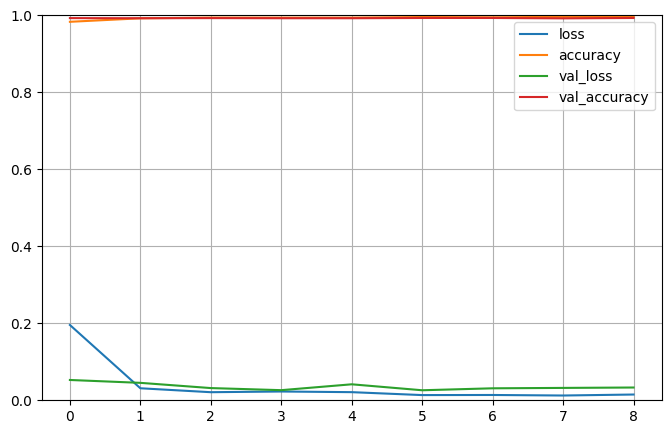

In [163]:
pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [165]:
# Evaluate on validation dataset
score = model.evaluate(val_set, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.033153634518384933
Val accuracy: 0.9929953217506409


In [166]:
# Evaluate on test dataset
score = model.evaluate(test_set, verbose=True)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

157/157 [==============================] - 28s 177ms/step - loss: 0.0235 - accuracy: 0.9948
Val loss: 0.02349771186709404
Val accuracy: 0.9948010444641113


Our own neural net scored 83.75% on test set whereas InceptionResNetV2 performed way better with almost 100% acuuracy on the test set!